# Car Price Prediction (Hackathon organised by TheMathCompany)

With the rise in the variety of cars with differentiated capabilities and features such as model, production year, category, brand, fuel type, engine volume, mileage, cylinders, colour, airbags and many more, we are bringing a car price prediction challenge for all. We all aspire to own a car within budget with the best features available. To solve the price problem we have created a dataset of 19237 for the training dataset and 8245 for the test dataset.

In [1]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import hp,fmin, tpe, Trials
from hyperopt.pyll.base import scope
from xgboost import XGBRegressor
from functools import partial
from sklearn import model_selection
from sklearn.metrics import r2_score, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading datasets
train_all = pd.read_csv("train.csv")
test_all = pd.read_csv("test.csv")

In [3]:
#Lets look at the traning set
train_all.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [4]:
#Lets look at the test set
test_all.head()

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,44020629,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN
1,45784798,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN
2,45800257,-,NISSAN,Tiida,2005,Sedan,No,Petrol,1.5,168000 km,4,Automatic,Front,04-May,Right-hand drive,Sky blue,8,NaN
3,45797981,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,3.2,143000 km,6,Automatic,4x4,04-May,Left wheel,Blue,12,NaN
4,45814303,-,OPEL,Astra,1993,Hatchback,No,Petrol,1.6,200000 km,4,Manual,Front,04-May,Left wheel,Black,0,NaN


In [5]:
#Checking for null in train
train_all.isnull().mean()

ID                  0.0
Price               0.0
Levy                0.0
Manufacturer        0.0
Model               0.0
Prod. year          0.0
Category            0.0
Leather interior    0.0
Fuel type           0.0
Engine volume       0.0
Mileage             0.0
Cylinders           0.0
Gear box type       0.0
Drive wheels        0.0
Doors               0.0
Wheel               0.0
Color               0.0
Airbags             0.0
dtype: float64

In [6]:
#Checking for null in test
test_all.isnull().mean()

ID                  0.0
Levy                0.0
Manufacturer        0.0
Model               0.0
Prod. year          0.0
Category            0.0
Leather interior    0.0
Fuel type           0.0
Engine volume       0.0
Mileage             0.0
Cylinders           0.0
Gear box type       0.0
Drive wheels        0.0
Doors               0.0
Wheel               0.0
Color               0.0
Airbags             0.0
Price               1.0
dtype: float64

## Data Cleaning

In [7]:
#I observed that in some cases Levy vaue is '-'. I assume that means Levy is not present. Thus, replacing that with 0

train_all['Levy']=train_all.Levy.apply(lambda x : 0 if x=='-' else int(x))
test_all['Levy']=test_all.Levy.apply(lambda x : 0 if x=='-' else int(x))

In [8]:
#From the Engine volume feature, creating new fearure Turbo, if Turbo is present in the filed

train_all['Turbo']=train_all['Engine volume'].apply(lambda x : 1 if 'TURBO' in x.upper() else 0)
test_all['Turbo']=test_all['Engine volume'].apply(lambda x : 1 if 'TURBO' in x.upper() else 0)

In [9]:
#From the Engine volume feature,removing the word Turbo

train_all['Engine volume'] = train_all['Engine volume'].apply(lambda x : float(x[:-5]) if 'TURBO' in x.upper() else float(x))
test_all['Engine volume'] = test_all['Engine volume'].apply(lambda x : float(x[:-5]) if 'TURBO' in x.upper() else float(x))

In [10]:
#Mileage column contains km, removing that

train_all['Mileage']=train_all.Mileage.apply(lambda x : int(x[:-2]))
test_all['Mileage']=test_all.Mileage.apply(lambda x : int(x[:-2]))

In [11]:
#Creating new feature Age of Car

train_all['Ageofcar']=train_all['Prod. year'].apply(lambda x : 2021-x)
test_all['Ageofcar']=test_all['Prod. year'].apply(lambda x : 2021-x)

## EDA

In [12]:
#Now, as the data has been cleaned lets have a look at the train set

train_all.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Ageofcar
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,0,11
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8,0,10
2,45774419,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,04-May,Right-hand drive,Black,2,0,15
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,04-May,Left wheel,White,0,0,10
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,04-May,Left wheel,Silver,4,0,7


In [13]:
#Lets look at the datatypes
train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  int64  
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  float64
 10  Mileage           19237 non-null  int64  
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [14]:
#Lets see the 7 point summary
train_all.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,19237.0,4.557654e+07,9.365914e+05,20746880.0,45698374.0,45772308.0,45802036.0,4.581665e+07
Price,19237.0,1.855593e+04,1.905813e+05,1.0,5331.0,13172.0,22075.0,2.630750e+07
Levy,19237.0,6.325287e+02,5.677217e+02,0.0,0.0,642.0,917.0,1.171400e+04
Prod. year,19237.0,2.010913e+03,5.668673e+00,1939.0,2009.0,2012.0,2015.0,2.020000e+03
Engine volume,19237.0,2.307990e+00,8.778045e-01,0.0,1.8,2.0,2.5,2.000000e+01
Mileage,19237.0,1.532236e+06,4.840387e+07,0.0,70139.0,126000.0,188888.0,2.147484e+09
Cylinders,19237.0,4.582991e+00,1.199933e+00,1.0,4.0,4.0,4.0,1.600000e+01
Airbags,19237.0,6.582627e+00,4.320168e+00,0.0,4.0,6.0,12.0,1.600000e+01
Turbo,19237.0,1.003795e-01,3.005131e-01,0.0,0.0,0.0,0.0,1.000000e+00
Ageofcar,19237.0,1.008718e+01,5.668673e+00,1.0,6.0,9.0,12.0,8.200000e+01


In [15]:
#Lets Analyse the Numerical Variables
num_vers=[var for var in train_all.columns if train_all[var].dtypes!='O']
train_all[num_vers].head()

,ID,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Turbo,Ageofcar
0,45654403,13328,1399,2010,3.5,186005,6.0,12,0,11
1,44731507,16621,1018,2011,3.0,192000,6.0,8,0,10
2,45774419,8467,0,2006,1.3,200000,4.0,2,0,15
3,45769185,3607,862,2011,2.5,168966,4.0,0,0,10
4,45809263,11726,446,2014,1.3,91901,4.0,4,0,7


In [16]:
# We will not use ID to make our predictions, as there is one different value of the variable per each row,
# i.e., each car in the dataset. 

In [17]:
# let's explore the values of these temporal variable(Prod.year)
train_all['Prod. year'].unique()

array([2010, 2011, 2006, 2014, 2016, 2013, 2007, 1999, 1997, 2018, 2008,
       2012, 2017, 2001, 1995, 2009, 2000, 2019, 2015, 2004, 1998, 1990,
       2005, 2003, 1985, 1996, 2002, 1993, 1992, 1988, 1977, 1989, 1994,
       2020, 1984, 1986, 1991, 1983, 1953, 1964, 1974, 1987, 1943, 1978,
       1965, 1976, 1957, 1980, 1939, 1968, 1947, 1982, 1981, 1973],
      dtype=int64)

Text(0.5, 1.0, 'Change in Car price with the years')

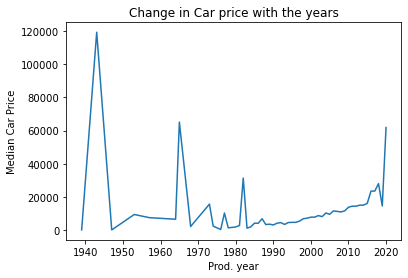

In [18]:
# We can explore the evolution of the sale price with the years in which the house was sold:
train_all.groupby('Prod. year')['Price'].median().plot()
plt.ylabel('Median Car Price')
plt.title('Change in Car price with the years')

In [19]:
# From the graph we can see there is spike for vintage cars

In [20]:
# Discrete variables

# Let's go ahead and find which variables are discrete, i.e., show a finite number of values

In [21]:
#  let's male a list of discrete variables
discrete_vars = [var for var in num_vers if len(
    train_all[var].unique()) < 20 and var not in['ID','Prod. year']]

# let's visualise the discrete variables
train_all[discrete_vars].head()

,Cylinders,Airbags,Turbo
0,6.0,12,0
1,6.0,8,0
2,4.0,2,0
3,4.0,0,0
4,4.0,4,0


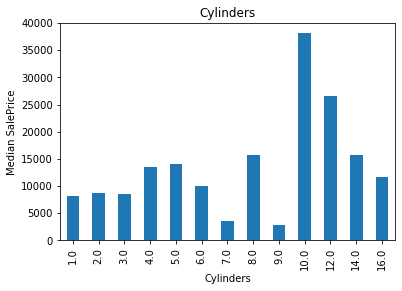

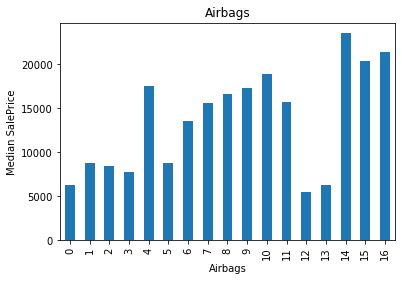

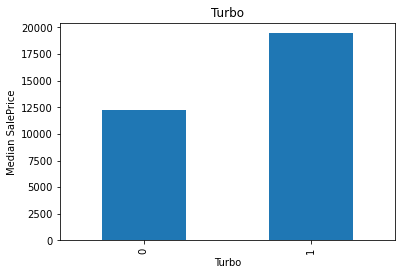

In [22]:
# Let's go ahead and analyse their contribution to the Car price.
def analyse_discrete(df, var):
    df = df.copy()
    df.groupby(var)['Price'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Median SalePrice')
    plt.show()
    
for var in discrete_vars:
    analyse_discrete(train_all, var)

In [23]:
# Continuous variables

# Let's go ahead and find the distribution of the continuous variables. 
# We will consider continuous variables to all those that are not temporal or discrete variables in our dataset.

In [24]:
# make list of continuous variables
cont_vars = [
    var for var in num_vers if var not in discrete_vars+['ID','Prod. year']]

# let's visualise the discrete variables
train_all[cont_vars].head()


,Price,Levy,Engine volume,Mileage,Ageofcar
0,13328,1399,3.5,186005,11
1,16621,1018,3.0,192000,10
2,8467,0,1.3,200000,15
3,3607,862,2.5,168966,10
4,11726,446,1.3,91901,7


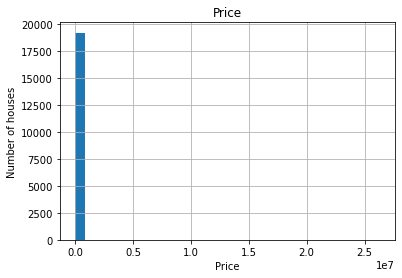

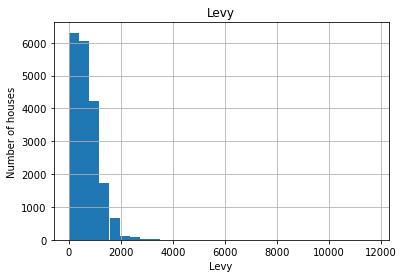

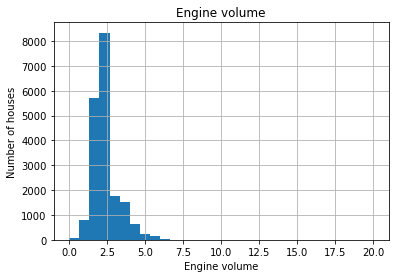

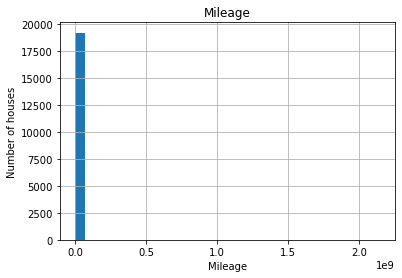

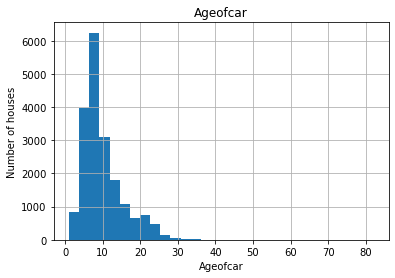

In [25]:
# Let's go ahead and analyse the distributions of these variables


def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of houses')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in cont_vars:
    analyse_continuous(train_all, var)

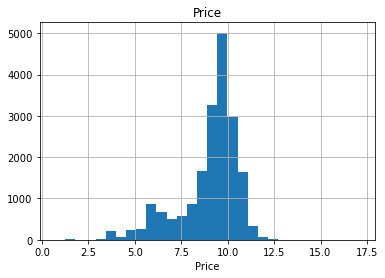

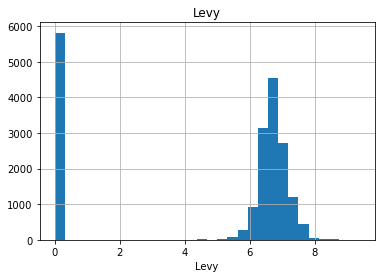

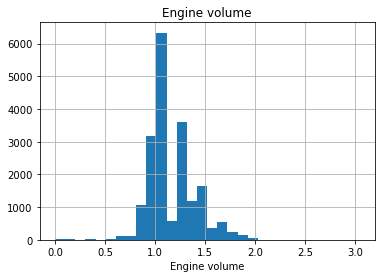

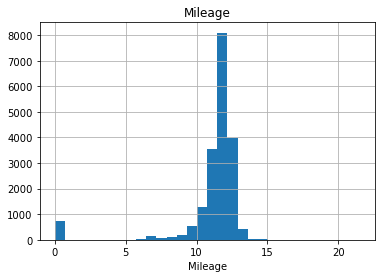

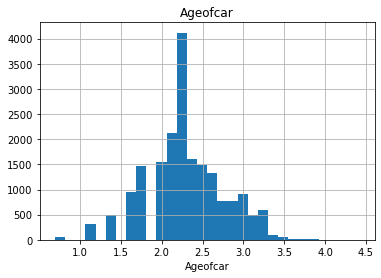

In [26]:
#As we can see, all contineous variables are skewed. 
# Let's go ahead and analyse the distributions of these variables
# after applying a logarithmic transformation


def analyse_transformed_continuous(df, var):
    df = df.copy()
    df[var] = np.log1p(df[var])
    df[var].hist(bins=30)
    plt.xlabel(var)
    plt.title(var)
    plt.show()
    


for var in cont_vars:
    analyse_transformed_continuous(train_all, var)

We get a better spread of the values for most variables when we use the logarithmic transformation. 
This engineering step will most likely add performance value to our final model.

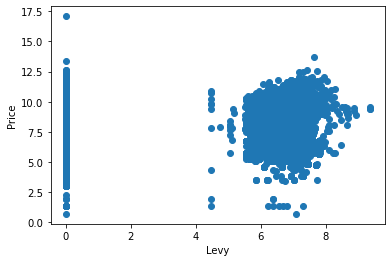

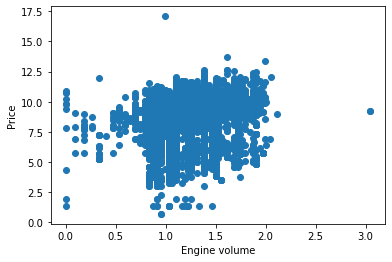

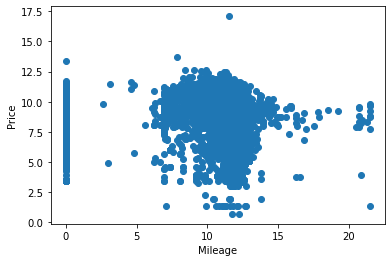

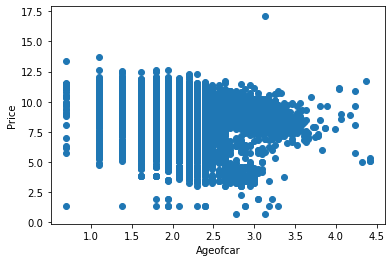

In [27]:
# let's explore the relationship between the Car price and
# the transformed variables with more detail:


def transform_analyse_continuous(df, var):
    df = df.copy()
    df[var] = np.log1p(df[var])
        
    # log transform the target (remember it was also skewed)
    df['Price'] = np.log1p(df['Price'])

    # plot
    plt.scatter(df[var], df['Price'])
    plt.ylabel('Price')
    plt.xlabel(var)
    plt.show()

for var in cont_vars:
    if var != 'Price':
        transform_analyse_continuous(train_all, var)

From the previous plots, we observe some monotonic associations between Price 
and the variables to which we applied the log transformation, for example 'Engine volume'.

### Outliers


Extreme values may affect the performance of a linear model. Let's find out if we have any in our variables.

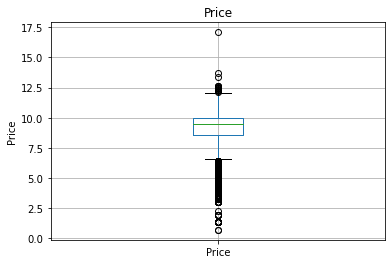

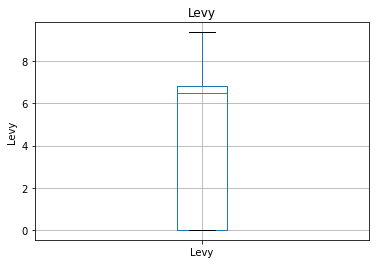

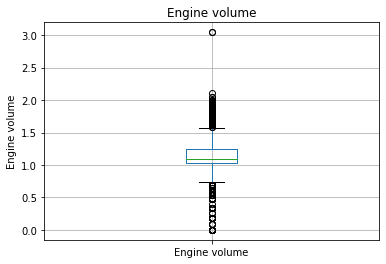

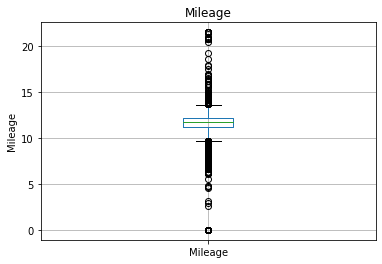

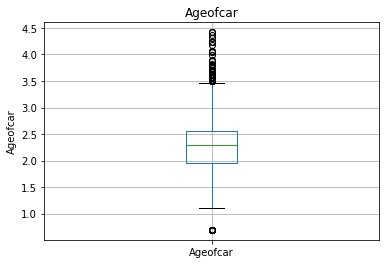

In [28]:
# let's make boxplots to visualise outliers in the continuous variables


def find_outliers(df, var):
    df = df.copy()
    df[var] = np.log1p(df[var])
    df.boxplot(column=var)
    plt.title(var)
    plt.ylabel(var)
    plt.show()


for var in cont_vars:
    find_outliers(train_all, var)

In [29]:
# The majority of the continuous variables seem to contain outliers. 
#Outliers tend to affect the performance of linear model.Will use Tree based model

In [30]:
# Categorical variables

# Let's go ahead and analyse the categorical variables present in the dataset.

In [31]:
# capture categorical variables in a list
cat_vars = [var for var in train_all.columns if train_all[var].dtypes == 'O']

# let's visualise the values of the categorical variables
train_all[cat_vars].head()

,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,04-May,Left wheel,Silver
1,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,04-May,Left wheel,Black
2,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,04-May,Right-hand drive,Black
3,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,04-May,Left wheel,White
4,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,04-May,Left wheel,Silver


### Number of labels: cardinality

In [32]:
# Let's evaluate how many different categories are present in each of the variables.

train_all[cat_vars].nunique()

Manufacturer          65
Model               1590
Category              11
Leather interior       2
Fuel type              7
Gear box type          4
Drive wheels           3
Doors                  3
Wheel                  2
Color                 16
dtype: int64

Model has high cardinality. We have to take care of this.

### Rare labels

In [33]:
# Let's go ahead and investigate now if there are labels that are present only in a small number of houses:

In [34]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['Price'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations


for var in cat_vars:
    print(analyse_rare_labels(train_all, var, 0.01))
    print()

Manufacturer
ACURA           0.000780
ALFA ROMEO      0.000208
ASTON MARTIN    0.000052
BENTLEY         0.000104
BUICK           0.000832
CADILLAC        0.000728
CHRYSLER        0.001352
CITROEN         0.000468
DAEWOO          0.004730
DAIHATSU        0.000676
DODGE           0.004730
FERRARI         0.000104
FIAT            0.004055
GAZ             0.000624
GMC             0.000780
GREATWALL       0.000052
HAVAL           0.000052
HUMMER          0.000260
INFINITI        0.001559
ISUZU           0.000208
JAGUAR          0.002183
JEEP            0.007174
LAMBORGHINI     0.000052
LANCIA          0.000052
LAND ROVER      0.002547
LINCOLN         0.000780
MASERATI        0.000208
MAZDA           0.009513
MERCURY         0.000208
MINI            0.002495
MOSKVICH        0.000208
PEUGEOT         0.000884
PONTIAC         0.000052
PORSCHE         0.002807
RENAULT         0.001923
ROLLS-ROYCE     0.000104
ROVER           0.000156
SAAB            0.000104
SATURN          0.000052
SCION       

In [35]:
# Some of the categorical variables show multiple labels that are present in less than 1% of the houses. We will engineer these variables in our next video. Labels that are under-represented in the dataset tend to cause over-fitting of machine learning models. That is why we want to remove them.

# Finally, we want to explore the relationship between the categories of the different variables and the house sale price:

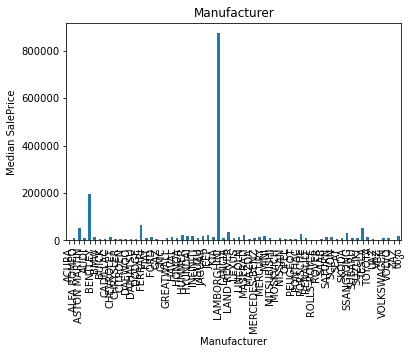

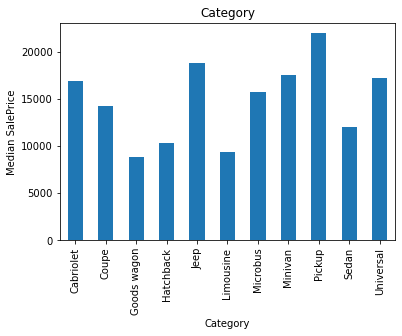

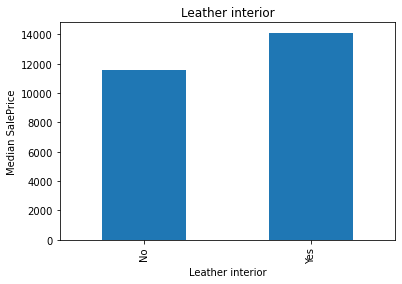

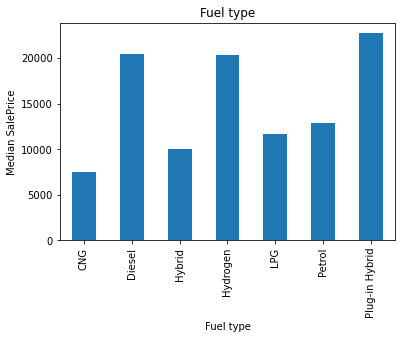

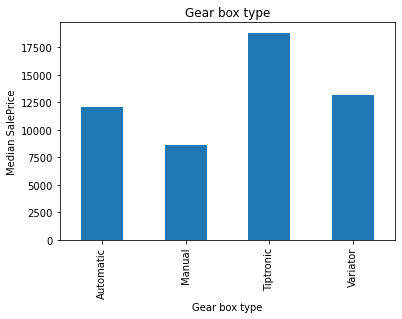

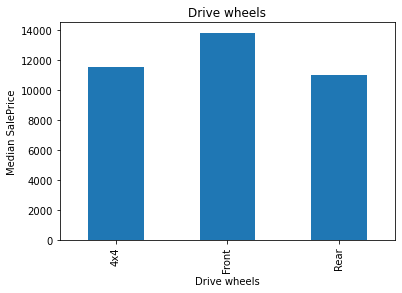

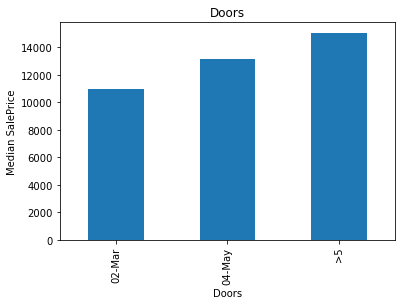

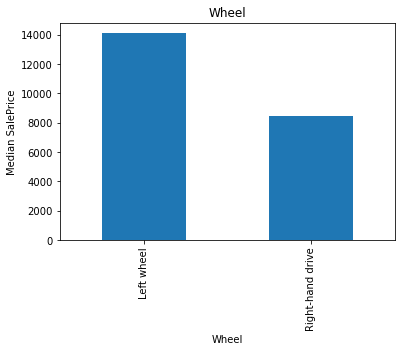

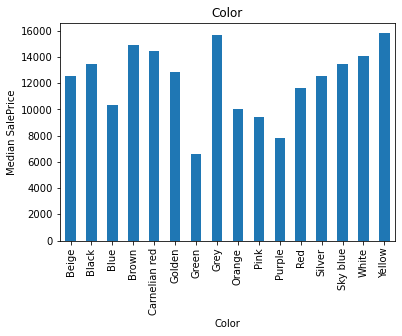

In [36]:
# Finally, we want to explore the relationship between the categories of the different variables and the house sale price:
for var in cat_vars:
    # we can re-use the function to determine median
    # sale price, that we created for discrete variables
    if var != 'Model':
        analyse_discrete(train_all, var)

We will transform these strings / labels into numbers, so that we capture this information and transform it into a monotonic relationship between the category and the Price.

## Feature Engineering

### Numerical variable transformation

In [37]:
# As we have seen taking log makes contineous numarical variables well distributed, going to take log transformation

for var in cont_vars:
    train_all[var] = np.log1p(train_all[var])
    if var !='Price':
        test_all[var] = np.log1p(test_all[var])
        

### Categorical variables

First, we will group those categories within variables that are present in less than 1% of the observations. 
That is, all values of categorical variables that are shared by less than 1% of houses, well be replaced by the string "Rare".

In [38]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)['Price'].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_vars + ['Prod. year']:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(train_all, var, 0.01)
    
    # replace rare categories by the string "Rare"
    train_all[var] = np.where(train_all[var].isin(
        frequent_ls), train_all[var], 'Rare')
    
    test_all[var] = np.where(test_all[var].isin(
        frequent_ls), test_all[var], 'Rare')

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. 
We will do it so that we capture the monotonic relationship between the label and the target.

In [39]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price


def replace_categories(train, test, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = train.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [40]:
for var in cat_vars + ['Prod. year']:
    replace_categories(train_all, test_all, var, 'Price')

In [41]:
# check absence of na in the train set
[var for var in train_all.columns if train_all[var].isnull().sum() > 0]

[]

In [42]:
# check absence of na in the test set
[var for var in test_all.columns if test_all[var].isnull().sum() > 0]

['Price']

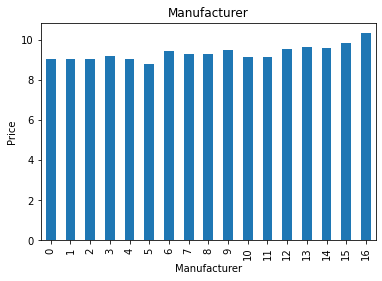

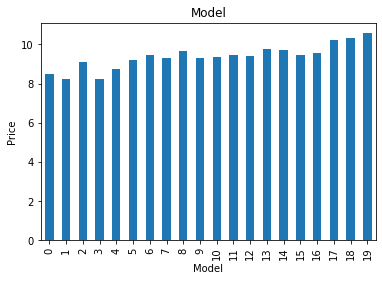

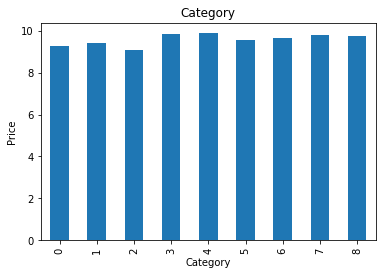

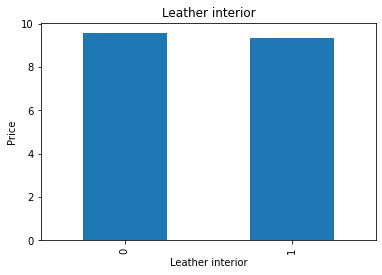

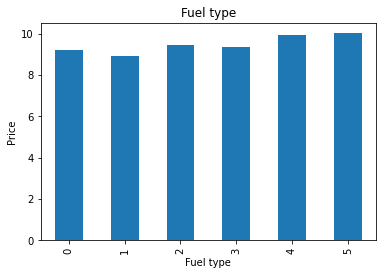

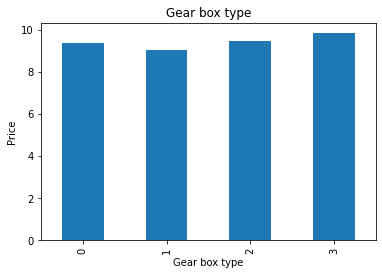

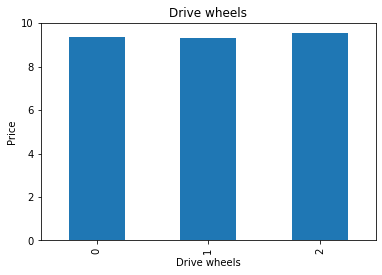

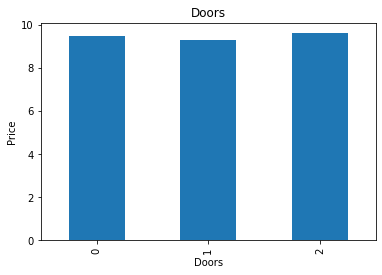

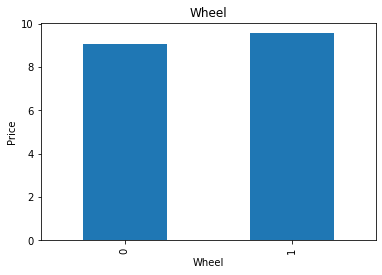

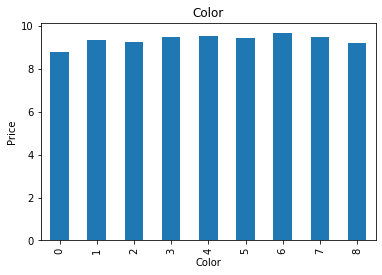

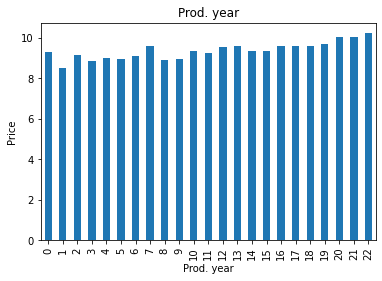

In [43]:
# let me show you what I mean by monotonic relationship
# between labels and target

def analyse_vars(df, var):
    
    # function plots median house sale price per encoded
    # category
    
    df = df.copy()
    df.groupby(var)['Price'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Price')
    plt.show()
    
for var in cat_vars+['Prod. year']:
    analyse_vars(train_all, var)

In [44]:
#Selecting final features 

final_features = [var for var in train_all.columns if var not in ['ID','Price'] ]
test_all[final_features].head()

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Ageofcar
0,0.000000,8,10,13,0,1,4,1.098612,0.000000,4,1,2,1,1,6,10,1,2.302585
1,0.000000,15,12,13,1,0,2,1.223775,10.165890,4,3,2,0,1,6,10,0,2.302585
2,0.000000,2,10,2,1,1,2,0.916291,12.031725,4,0,2,0,0,7,8,0,2.833213
3,6.883463,10,10,13,3,0,2,1.435085,11.870607,6,0,0,0,1,2,12,0,2.302585
4,0.000000,5,10,1,0,1,2,0.955511,12.206078,4,1,2,0,1,3,0,0,3.367296


In [45]:
#Deviding data into dependent and independent set for predicting FitmentPercent
X = train_all[final_features].values
y = train_all.Price.values

In [46]:
#Scaling the data

from sklearn.preprocessing import StandardScaler
scaller = StandardScaler()
X = scaller.fit_transform(X) 
test_all[final_features] = scaller.transform(test_all[final_features])

In [47]:
# Optimizing the parameters for regression

# def optimize(params, x,y):
#     model = XGBRegressor(**params)
#     kf = model_selection.KFold(n_splits=5)
#     accuracies = []
#     for idx in kf.split(X=x,y=y):
#         train_idx,test_idx = idx[0],idx[1]
#         xtrain = x[train_idx]
#         ytrain = y[train_idx]
        
#         xtest = x[test_idx]
#         ytest = y[test_idx]
        
#         model.fit(xtrain,ytrain)
#         preds =  model.predict(xtest)
        
# #         fold_acc = r2_score(np.expm1(ytest), np.expm1(preds))
        
# #         fold_acc = np.sqrt(mean_squared_log_error(ytest,preds))

#         fold_acc = r2_score(ytest,preds)
#         accuracies.append(fold_acc)
#     return -1.0 * np.mean(accuracies)

# param_space = {
#     "max_depth" : scope.int(hp.quniform("max_depth",3,20, 1)) ,
#     "min_child_weight" : scope.int(hp.quniform("min_child_weight",1,8, 1)),
#     "n_estimators": scope.int(hp.quniform("n_estimators",100,1500,1)),
#     'learning_rate': hp.uniform("learning_rate",0.01,1),
#     'reg_lambda': hp.uniform("reg_lambda",0.01,1),
#     'gamma': hp.uniform("gamma",0.01,1),
#     'subsample': hp.uniform("subsample",0.01,1)
#     }
    
# optimization_fuction = partial(optimize,x = X, y = y) 
# trials = Trials()
# result = fmin(
#     fn = optimization_fuction,
#     space = param_space,
#     algo = tpe.suggest,
#     max_evals = 10,
#     trials = trials
# )
# print(result)

In [48]:
#Final Model
Xgb_regressor = XGBRegressor(gamma= 0.5426880200730636, 
                             learning_rate = 0.05597428082575337,
                             max_depth = 17,
                             min_child_weight = 2, 
                             n_estimators = 1238,
                             reg_lambda = 0.9854720412382376,
                             subsample = 0.4963644513337918)



0.25342413015366927
0.6968166394532589


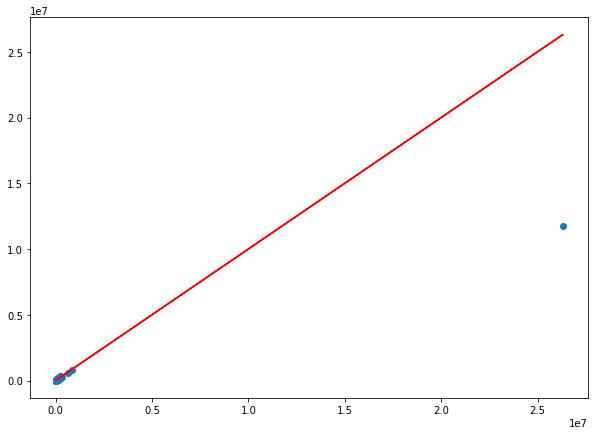

In [49]:
#Getting the test prediction
Xgb_regressor.fit(X,y)
Reg_pred = Xgb_regressor.predict(X)

error = np.sqrt(mean_squared_log_error(np.expm1(y), np.expm1(Reg_pred)))
r2=r2_score(np.expm1(y), np.expm1(Reg_pred))
print(error)
print(r2)

#Ploting the prediction on train set
plt.figure(figsize=[10,7])
plt.plot(np.expm1(y),np.expm1(y),color='red')
plt.scatter(np.expm1(y),np.expm1(Reg_pred))

plt.show()

# 0.2547824571682838
# 0.771597957597467

In [50]:
#Now, for getting the prediction for the test set

test_all['Price'] = np.expm1(Xgb_regressor.predict(test_all[final_features].values)) 

In [51]:
#Saving final output
test_all['Price'].to_csv('submission.csv', index=False)